### 1. Importing all the libraries, checking for Tensorflow 2 and setting the seeds

In [195]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

2.4.1


### 2. Helper functions for the visualisation

In [196]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

### 3. Mounting your Google Drive



In [197]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import os

# #!ls '/content/gdrive/My Drive/'

### 4. Loading the data

In [198]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), (x_test , r_test_class ) = cifar100.load_data(label_mode='coarse')

num_classes = 20

val_size = 6000
# make validation set
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=val_size, random_state=0)

# let's again take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

# You can again use a subset of the training data for initial exploration
# In this case, 10000 samples is really too small, so we suggest 20000

x_train_small = x_train[:20000]
r_train_small_class = r_train_class[:20000]

# And we do the same standardization as in the first assignment
x_train_all = x_train_all.astype('float32') #All the training samples
x_train = x_train.astype('float32') #All the training samples, without the validation samples
x_train_small = x_train_small.astype('float32') #Part of the training samples
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0
x_test /= 255.0

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_train_small = tf.keras.utils.to_categorical(r_train_small_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)
r_test = tf.keras.utils.to_categorical(r_test_class, num_classes)

# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')


x_train shape: (44000, 32, 32, 3)
44000 train samples
6000 validation samples
10000 test samples



###5. Visualisation of a few training samples


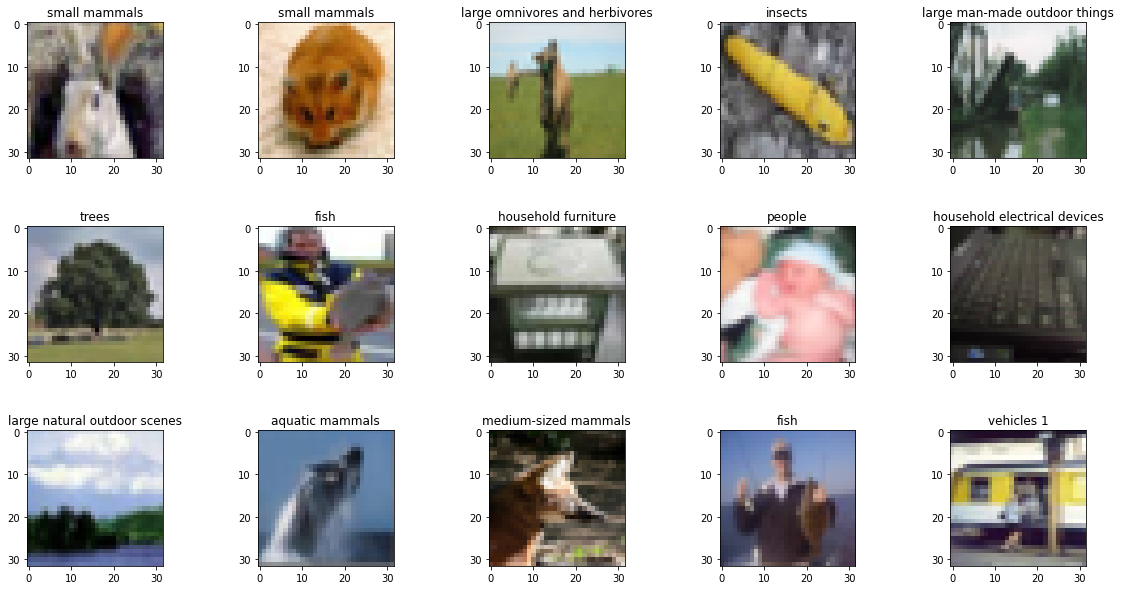

In [199]:
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title(labels[r_train_class[idx,0]])
    plt.imshow(x_train[idx],  interpolation='None')

###6. Create initial model without regularization

In [200]:
def initial_model():
  model = Sequential()

  # Convolutional layers
  model.add(Conv2D(64, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
 
  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(512, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  # end of convolutional layers, start of 'hidden' dense layers (can be more than 1 if necessary)
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
 
  # Final dense layer = linear classifier
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
 
  opt = tf.keras.optimizers.Adam(learning_rate = 0.00025) #using defaults for now
 
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
 
  return model

###7. Training and checking the power of our initial model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_48 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)       

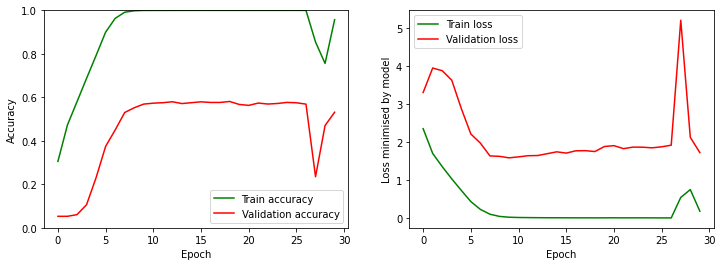

In [201]:
batch_size = 512
epochs = 30

# checkpoint and early stopping code from first assignment is introduced in comments:
# use or replace by your preferred workflow 
# do not forget to reload best model for evaluation after using early stopping (re-use code from first assignment)

model_1 = initial_model()
model_1.summary()

history_1 = model_1.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
          shuffle=True)

# Run code below to save the weights of final trained model:
# (not very useful in combination with modelcheckpoint, because then you would revert to the best model afterwards)
#model_1.save_weights(model_savename)

# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

###8. Adding regularisation to the initial model

In [202]:
def initial_model():
  model = Sequential()
  maxnorm_conv2D = 1
  maxnorm_dense = 1
  l1 = 1e-6
  l2 = 1e-3
 
  # Convolutional layers
  model.add(Conv2D(64, (3, 3), padding='same', kernel_constraint=max_norm(maxnorm_conv2D), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2),input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same', kernel_constraint=max_norm(maxnorm_conv2D), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))
  
  model.add(Conv2D(128, (3, 3), padding='same', kernel_constraint=max_norm(maxnorm_conv2D), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same', kernel_constraint=max_norm(maxnorm_conv2D), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.4))
 
  model.add(Conv2D(512, (3, 3), padding='same', kernel_constraint=max_norm(maxnorm_conv2D), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(512, (3, 3), padding='same', kernel_constraint=max_norm(maxnorm_conv2D), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.6))
  
  # end of convolutional layers, start of 'hidden' dense layers (can be more than 1 if necessary)
  model.add(Flatten())
  model.add(Dense(512, kernel_constraint=max_norm(maxnorm_dense), kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  model.add(Activation('relu'))
  model.add(Dropout(0.6))
 
  # Final dense layer = linear classifier
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
 
  opt = tf.keras.optimizers.Adam(learning_rate = 0.00025) #using defaults for now
 
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
 
  return model

### 9. Training and evaluating the regularised model



Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 64)        0         
__________________________________________

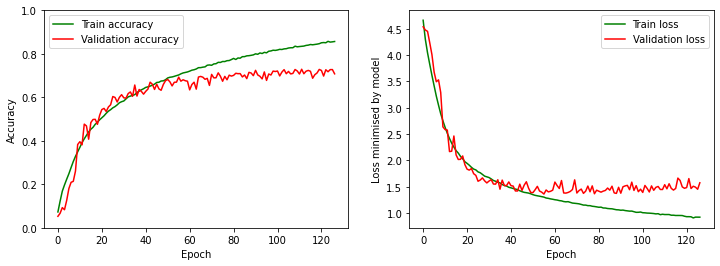

In [203]:
batch_size = 512
epochs = 150

# checkpoint and early stopping code from first assignment is introduced in comments:
# use or replace by your preferred workflow 
# do not forget to reload best model for evaluation after using early stopping (re-use code from first assignment)

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/"
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"initialmodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"


model_1 = initial_model()
model_1.summary()

#code for modelcheckpoint and early stopping  commented below
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor='val_accuracy',
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15,min_delta=0.0001)

history_1 = model_1.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
         callbacks = [stopping_callback, cp_callback],
          shuffle=True)

model_1.save_weights(model_savename)

# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

###10. Reconstructing the best performing model encountered during training (based on validation score)


In [205]:
#Reconstruct the best model encountered during training. This was saved by the ModelCheckpoint. 
#Since we told it to 'save_best_only', it has saved model weights each time an improvement occurred. 
#Our best model is therefore the last of the saved checkpoints.
import pathlib

# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)
checkpoints

/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0112.ckpt


[PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0004.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0019.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0027.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0035.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0037.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0038.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0039.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0041.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0042.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0045.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0053.ckpt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/cp-0059.ckpt'),
 PosixPath('/content/gdrive/My Drive/Col

In [206]:
# Now restore the model
best_model_1 = initial_model() # this is a new model
best_model_1.load_weights(latest)

# The code below should give slightly better results than that for the original model
[train_loss, train_accuracy] = best_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = best_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))


Training set Accuracy: 0.9381
Training set Loss:0.653056

Validation set Accuracy: 0.7292
Validation set Loss:1.460938



###11. Data augmentation (with train and validation set)

In [207]:
batch_size = 512
epochs = 150

au_model = initial_model()
au_model.summary()
au_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# dummy file path here ... this is local on Colab!
filepath = 'au_model.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.0001),
             ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)]

datagen = ImageDataGenerator(
        # rotation_range=15.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        # vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        # zoom_range = 0.2)  
        #shear_range = 15
)

# Compute quantities required for some augmentation functions
# (e.g., std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train, augment=True)

# Fit the model on the batches generated by datagen.flow().
au_history = au_model.fit(datagen.flow(x_train, r_train, batch_size=batch_size),
                                    epochs=epochs, steps_per_epoch=len(x_train) / batch_size,
                                    validation_data=(x_val, r_val),
                                    callbacks = callbacks)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_72 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_55 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_73 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 64)       

In [208]:
[train_loss, train_accuracy] = au_model.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = au_model.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))


Training set Accuracy:   0.78
Training set Loss: 1.4303

Validation set Accuracy:   0.70
Validation set Loss: 1.7689



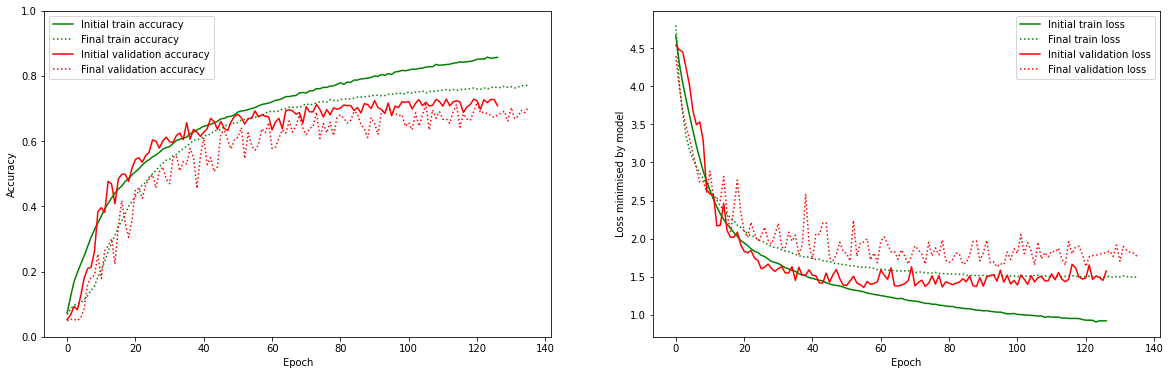

In [209]:
def plot_dual_history(before,after):
  plt.figure(figsize = (20,6))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(before.epoch, np.array(before.history['accuracy']),'g-',
           label='Initial train accuracy')
  plt.plot(after.epoch, np.array(after.history['accuracy']),'g:',
           label='Final train accuracy')
  plt.plot(before.epoch, np.array(before.history['val_accuracy']),'r-',
           label = 'Initial validation accuracy')
  plt.plot(after.epoch, np.array(after.history['val_accuracy']),'r:',
           label = 'Final validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(before.epoch, np.array(before.history['loss']),'g-',
           label='Initial train loss')
  plt.plot(after.epoch, np.array(after.history['loss']),'g:',
           label='Final train loss')
  plt.plot(before.epoch, np.array(before.history['val_loss']),'r-',
           label = 'Initial validation loss')
  plt.plot(after.epoch, np.array(after.history['val_loss']),'r:',
           label = 'Final validation loss')
  plt.legend()

plot_dual_history(history_1, au_history)

###12. Final model training on full training data (without augmentation)
Here, we re-train it on the full original training set (i.e., including the validation set) and use the number of EPOCHS that corresponds to our best validation score in the previous run (which is 112). Once this re-training has been done, we analyse how our network performs on the test set.

In [210]:
model_for_test = initial_model()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 512
epochs = 112

history_for_test = model_for_test.fit(x_train_all, r_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )

Epoch 1/112
98/98 [==============================] - 18s 161ms/step - loss: 5.0794 - accuracy: 0.0695
Epoch 2/112
98/98 [==============================] - 16s 163ms/step - loss: 4.3229 - accuracy: 0.1223
Epoch 3/112
98/98 [==============================] - 16s 162ms/step - loss: 4.0582 - accuracy: 0.1628
Epoch 4/112
98/98 [==============================] - 16s 162ms/step - loss: 3.8048 - accuracy: 0.1997
Epoch 5/112
98/98 [==============================] - 16s 161ms/step - loss: 3.5442 - accuracy: 0.2349
Epoch 6/112
98/98 [==============================] - 16s 162ms/step - loss: 3.3094 - accuracy: 0.2720
Epoch 7/112
98/98 [==============================] - 16s 162ms/step - loss: 3.1022 - accuracy: 0.3016
Epoch 8/112
98/98 [==============================] - 16s 162ms/step - loss: 2.9277 - accuracy: 0.3253
Epoch 9/112
98/98 [==============================] - 16s 162ms/step - loss: 2.7790 - accuracy: 0.3471
Epoch 10/112
98/98 [==============================] - 16s 162ms/step - loss: 2.616

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

Now, we will save the whole model, i.e., both the network structure and the weights, because that makes it easier to analyse it in a separate notebook.

In [ ]:
#the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
modelpath = checkpoint_dir+"final_model.h5"

print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model_for_test.save(modelpath)

Measuring the performance of the final model (on the test set)

In [ ]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = model_for_test.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[test_loss, test_accuracy] = model_for_test.evaluate(x_test, r_test, verbose=0)
print("Test set Accuracy:{:7.4f}".format(test_accuracy))
print("Test set Loss:{:7.6f}\n".format(test_loss))

###13. Final model training on full training data (with augmentation)
Here, we re-train it on the full original training set (i.e., including the validation set) and use the number of EPOCHS that corresponds to our best validation score in the previous run (which is X), together with data augmentation. Once this re-training has been done, we analyse how our network performs on the test set.

In [ ]:
batch_size = 512
epochs = 150

au_model_for_test = initial_model()
au_model_for_test.summary()
au_model_for_test.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# dummy file path here ... this is local on Colab!
filepath = 'au_model_for_test.h5'

datagen = ImageDataGenerator(
        # rotation_range=15.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        # vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        # zoom_range = 0.2)  
        #shear_range = 15
)

# Compute quantities required for some augmentation functions
# (e.g., std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train_all, augment=True)

# Fit the model on the batches generated by datagen.flow().
au_history_for_test = au_model_for_test.fit(datagen.flow(x_train_all, r_train_all, batch_size=batch_size),
                                    epochs=epochs, steps_per_epoch=len(x_train_all) / batch_size,
                                    validation_data=(x_val, r_val),
                                    callbacks = callbacks)

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(au_history_for_test.epoch, np.array(au_history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(au_history_for_test.epoch, np.array(au_history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

In [ ]:
#the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
modelpath = checkpoint_dir+"au_model_for_test.h5"

print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
au_model.save(modelpath)

In [ ]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = au_model_for_test.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[test_loss, test_accuracy] = au_model_for_test.evaluate(x_test, r_test, verbose=0)
print("Test set Accuracy:{:7.4f}".format(test_accuracy))
print("Test set Loss:{:7.6f}\n".format(test_loss))

### 14. Further analysis on the test set (model without data augmentation)

1.   Misclassification
2.   Confusion Matrix



Now the predictions are carried out on test set and analysed for misclassified samples.

In [71]:
from sklearn.metrics import precision_recall_fscore_support as score

# Return Label from one hot encoding
def return_label(one_hot_lab):
    op = np.zeros(len(one_hot_lab))
    for i in range(len(one_hot_lab)):
        op[i] = np.argmax(one_hot_lab[i])
    return op.astype(int)

#Get the real label and not the on hot encoded label
r_test_label = return_label(r_test)

predictions = model_for_test.predict(x_test)
# final_model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Models/final_model/Checkpoints/final_model.h5')

# the predictions are class probabilities, 
# the argmax code line below finds the index of the class with the highest probability

test_predicted_class = np.argmax(predictions,axis=1)
misclassified = np.where(test_predicted_class!=r_test_label)[0]

In [73]:
# misclassified is a vector that contains the indices of all misclassified samples

print("There are ",misclassified.shape[0]," misclassified samples in the test set.")


precision, recall, f1, _ = score(r_test_label, test_predicted_class)

There are  3162  misclassified samples in the test set.


In [189]:
# the functions below have been borrowed/adapted from the notebook:
# https://www.tensorflow.org/tutorials/keras/classification

from PIL import Image

# this function plots the image with some annotations
def plot_image(predictions, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Predicted:{} {:2.0f}% \n(Real:{})".format(labels[predicted_label],
                                100*np.max(predictions),
                                labels[true_label]),
                                color=color)


# this function shows the predictions for this sample
def plot_value_array(predictions, true_label):
  plt.grid(False)
  tick_marks = np.arange(20)
  perc = np.linspace(0,1,11)
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(perc)
  thisplot = plt.bar(range(20), predictions, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions)
  plt.xlabel('Label')
  plt.ylabel('Prediction confidence')

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

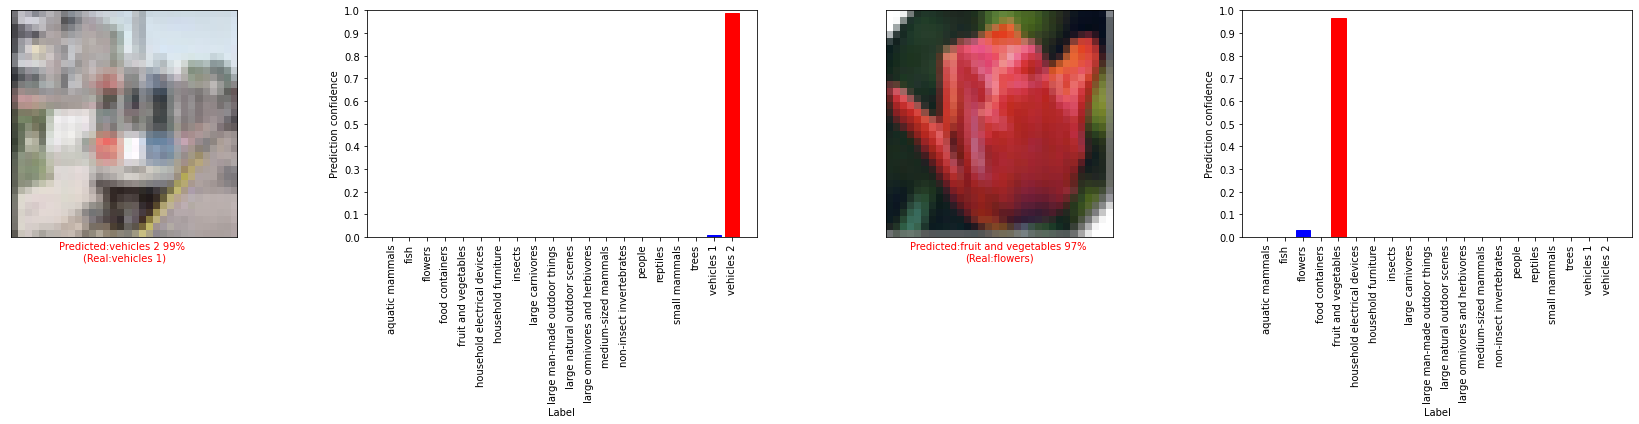

In [194]:
# probabilities for class that will be predicted
maxprob = np.max(predictions, axis=1)

# find 100 most certain misclassified samples
most_certain = np.argsort(maxprob[misclassified])
most_certain = misclassified[most_certain[-100:]]
np.random.shuffle(most_certain)

# now we visualise the samples we found

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 1
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*(num_cols+4), 2*(num_rows+2)))
for i in range(num_images):
  idx=most_certain[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[idx], r_test_label[idx], np.reshape(x_test[idx],(32,32,3)))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[idx], r_test_label[idx])
plt.tight_layout()
plt.show()

2. Confusion Matrices

In [118]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [146]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (13,13))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


Confusion matrix, without normalization


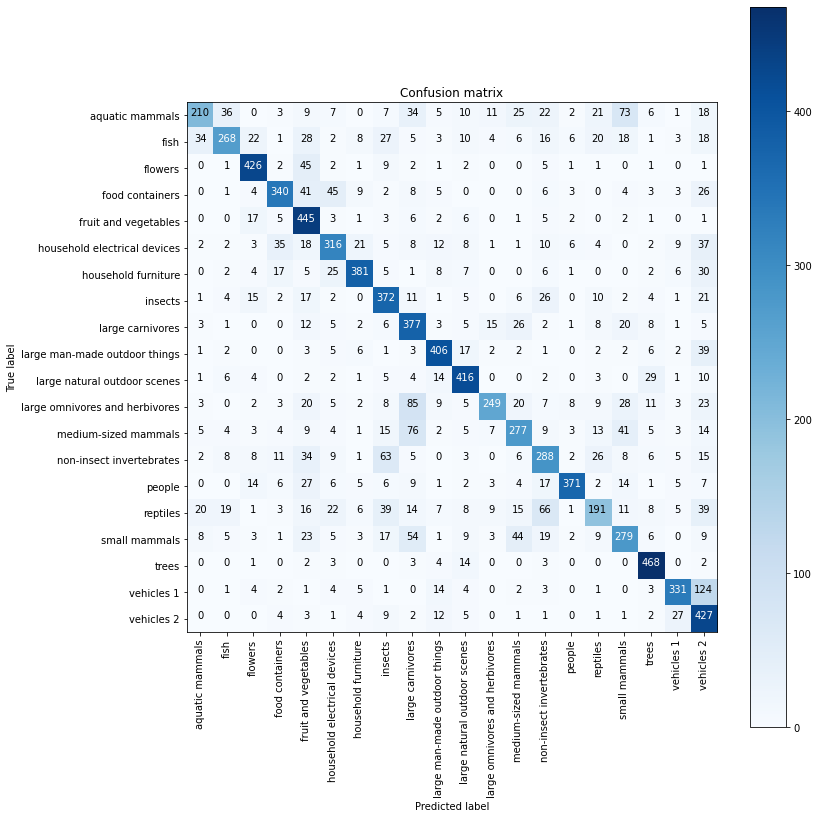

In [120]:
# An unnormalised confusion matrix shows the numbers of samples in each combination of true class/predicted class

plot_confusion_matrix(r_test_label, test_predicted_class)

Normalized confusion matrix


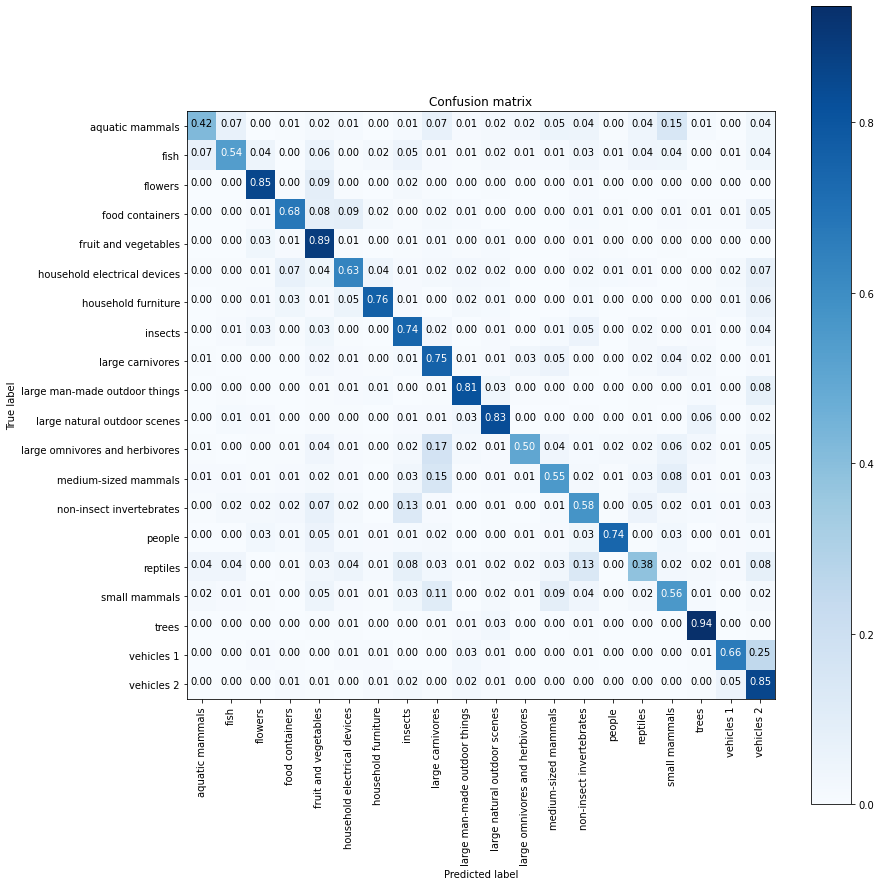

In [147]:
# A normalised confusion matrix shows for each true class, which fraction of its samples is predicted in each class
# since off-diagonal numbers are hopefully small, this is sometimes less informative

# for perfectly balances tasks, both should give the same information
# for (strongly) unbalanced tasks, they give complementary views

plot_confusion_matrix(r_test_label, test_predicted_class, normalize=True)